In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/joe/Documents/boulot/git/homhots/HOTS


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from HOTS.ToolsMonitor import (
    DisplaySurface2D,
    GenerateActivationMap,
    DisplayActivationMap,
    DisplayImage,
    DisplayConvergence,
)
from HOTS.STS import STS
from HOTS.Event import Event  # , Filters
from HOTS.KmeansLagorce import KmeansLagorce
from HOTS.Layer import FilterNHBD, ClusteringLayer
from HOTS.Tools import SaveObject, LoadObject
from HOTS.Network import Network
import time

In [3]:
## Definition of the General parameters

In [8]:
tau = 0.02
R = 2
nb_cluster = [4, 8, 16]
ImageSize = (32, 32)

# Train the Hierarchical Network Step by Step
## Loading the events

In [9]:
image_list = [1, 32, 19, 22, 29]
event0 = Event(ImageSize=(32, 32))

event0.LoadFromMat("Data/alphabet_ExtractedStabilized.mat", image_number=image_list)

##  Initial Filtering

In [10]:
InputFilter = FilterNHBD(threshold=15, neighbourhood=2)
event1 = InputFilter.RunLayer(event0)

##  Step by step Training

In [11]:
## Layer1
SpTe_Layer1 = STS(tau=tau, R=R, verbose=1)
Surface_Layer1 = SpTe_Layer1.create(event=event1)
ClusterLayer1 = KmeansLagorce(nb_cluster=nb_cluster[0], to_record=True, verbose=1)
Prototype1 = ClusterLayer1.fit(SpTe_Layer1)
event2, _ = ClusterLayer1.predict(Surface=SpTe_Layer1.Surface, event=event1)

## Layer2
SpTe_Layer2 = STS(tau=10 * tau, R=2 * R, verbose=1)
Surface_Layer2 = SpTe_Layer2.create(event=event2)
ClusterLayer2 = KmeansLagorce(nb_cluster=nb_cluster[1], to_record=True, verbose=1)
Prototype2 = ClusterLayer2.fit(SpTe_Layer2)
event3, _ = ClusterLayer2.predict(Surface=SpTe_Layer2.Surface, event=event2)

## Layer3
SpTe_Layer3 = STS(tau=10 * 10 * tau, R=2 * 2 * R, verbose=1)
Surface_Layer3 = SpTe_Layer3.create(event=event3)
ClusterLayer3 = KmeansLagorce(nb_cluster=nb_cluster[2], to_record=True, verbose=1)
Prototype3 = ClusterLayer3.fit(SpTe_Layer3)
event4, _ = ClusterLayer3.predict(Surface=SpTe_Layer3.Surface, event=event3)

Generation of SpatioTemporal Surface in ------ 1.31 s
Clustering SpatioTemporal Surface in ------ 31.69 s
Generation of SpatioTemporal Surface in ------ 1.63 s
Clustering SpatioTemporal Surface in ------ 40.77 s
Generation of SpatioTemporal Surface in ------ 4.27 s
Clustering SpatioTemporal Surface in ------ 135.06 s


## Monitoring

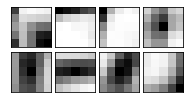

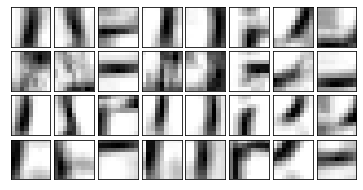

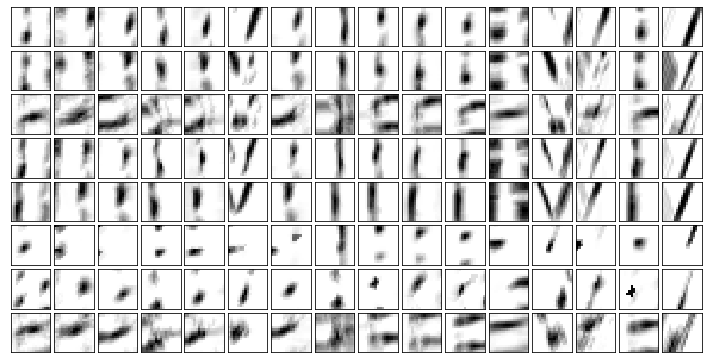

In [12]:
for proto, nb_polarities in zip([Prototype1, Prototype2, Prototype3], nb_cluster):
    DisplaySurface2D(proto, nb_polarities=nb_polarities//2)

# Using the Layer object: Condensed code for initial filtering and training

In [13]:
## defining the Network
InputFilter = FilterNHBD(threshold=15, neighbourhood=2)
L1 = ClusteringLayer(
    tau=tau,
    R=R,
    verbose=1,
    ThrFilter=0,
    LearningAlgo="lagorce",
    kernel="exponential",
    eta=None,
    eta_homeo=None,
    sigma=None,
)
L2 = ClusteringLayer(
    tau=10 * tau,
    R=2 * R,
    verbose=1,
    ThrFilter=0,
    LearningAlgo="lagorce",
    kernel="exponential",
    eta=None,
    eta_homeo=None,
    sigma=None,
)
L3 = ClusteringLayer(
    tau=10 * 10 * tau,
    R=2 * 2 * R,
    verbose=1,
    ThrFilter=0,
    LearningAlgo="lagorce",
    kernel="exponential",
    eta=None,
    eta_homeo=None,
    sigma=None,
)
Net = Network([InputFilter, L1, L2, L3])

In [14]:
ClusterLayer, event_output = Net.TrainCluster(
    event=event0, NbClusterList=nb_cluster, to_record=True, NbCycle=1
)

Generation of SpatioTemporal Surface in ------ 1.32 s
Clustering SpatioTemporal Surface in ------ 41.14 s
Generation of SpatioTemporal Surface in ------ 1.74 s
Clustering SpatioTemporal Surface in ------ 47.19 s
Generation of SpatioTemporal Surface in ------ 5.52 s
Clustering SpatioTemporal Surface in ------ 150.44 s


##    Monitoring

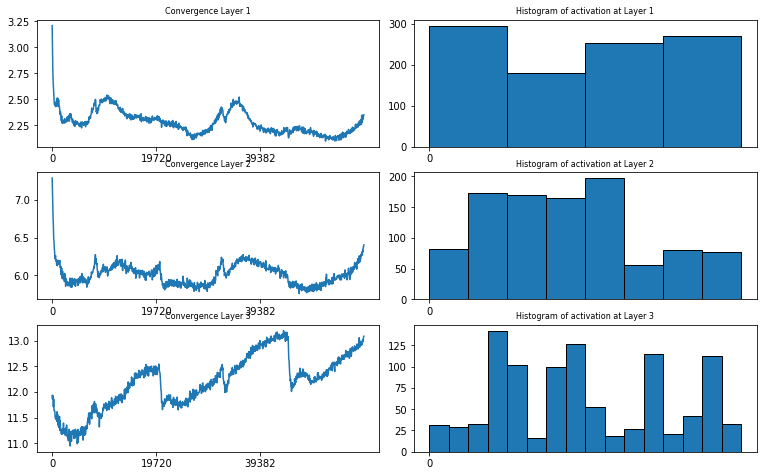

In [15]:
DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

# Running the trained network on a single image
## Step by Step

In [17]:
## Loading and filter an image of a 8
event0 = Event(ImageSize=(32, 32))
event0.LoadFromMat("Data/alphabet_ExtractedStabilized.mat", image_number=22)

In [18]:
InputFilter = FilterNHBD(threshold=15, neighbourhood=2)
event1 = InputFilter.RunLayer(event0)

## Layer1
SpTe_Layer1 = STS(tau=tau, R=R, verbose=1)
Surface_Layer1 = SpTe_Layer1.create(event=event1)
event2, _ = ClusterLayer1.predict(Surface=SpTe_Layer1.Surface, event=event1)

## Layer2
SpTe_Layer2 = STS(tau=10 * tau, R=2 * R, verbose=1)
Surface_Layer2 = SpTe_Layer2.create(event=event2)
event3, _ = ClusterLayer2.predict(Surface=SpTe_Layer2.Surface, event=event2)

## Layer3
SpTe_Layer3 = STS(tau=10 * 10 * tau, R=2 * 2 * R, verbose=1)
Surface_Layer3 = SpTe_Layer3.create(event=event3)
event4, _ = ClusterLayer3.predict(Surface=SpTe_Layer3.Surface, event=event3)

Generation of SpatioTemporal Surface in ------ 0.31 s
Generation of SpatioTemporal Surface in ------ 0.43 s
Generation of SpatioTemporal Surface in ------ 0.88 s


## Condensed code using the Layer object

Once the Network has been defined, we can run it in one line:

In [19]:
event0_o = Net.RunNetwork(event0, NbClusterList=ClusterLayer)

Generation of SpatioTemporal Surface in ------ 0.30 s
Generation of SpatioTemporal Surface in ------ 0.38 s
Generation of SpatioTemporal Surface in ------ 1.13 s


## Generating and Monitoring the activation map 

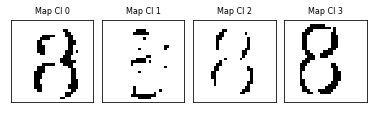

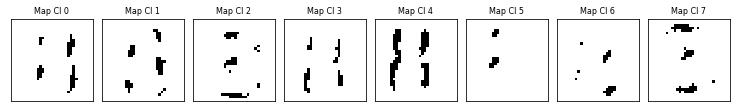

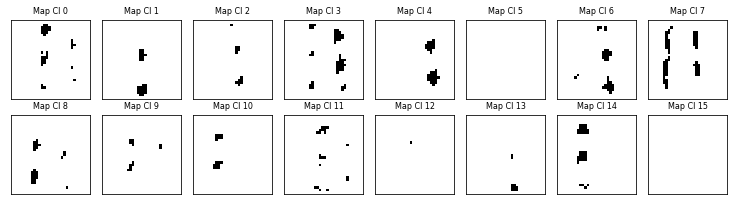

In [20]:
mapL1 = GenerateActivationMap(Net.Layers[1].output, ClusterLayer[0])
DisplayActivationMap(mapL1)
mapL2 = GenerateActivationMap(Net.Layers[2].output, ClusterLayer[1])
DisplayActivationMap(mapL2)
mapL3 = GenerateActivationMap(Net.Layers[3].output, ClusterLayer[2])
DisplayActivationMap(mapL3)

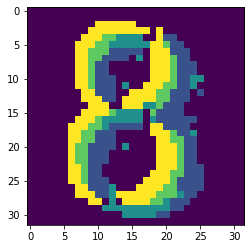

In [21]:
mapGlobal_L1 = GenerateActivationMap(Net.Layers[1].output, ClusterLayer[0], mode="global")
plt.imshow(mapGlobal_L1);

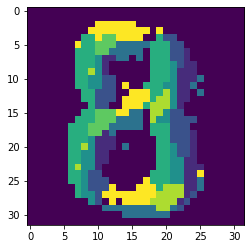

In [22]:
mapGlobal_L2 = GenerateActivationMap(Net.Layers[2].output, ClusterLayer[1], mode="global")
plt.imshow(mapGlobal_L2);

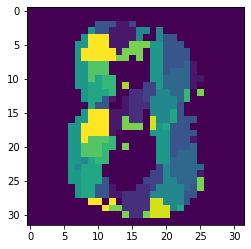

In [23]:
mapGlobal_L3 = GenerateActivationMap(Net.Layers[3].output, ClusterLayer[2], mode="global")
plt.imshow(mapGlobal_L3);